# Линейные классификаторы
КБ-211 Коренев Денис

**Задание:** Построить линейную дискриминантную функцию Фишера для классификации на два класса. Разбивку на классы сделать  по столбцу "правильных ответов". Если этот столбец непонятно как определить (можно спросить о нем у преподавателя), то использовать  разбиение на 2 кластера в задании 2 или 3. Классификацию проводить по всем признакам, а для визуализации использовать два наиболее значимых или главные компоненты из задания 3. В этом задании не использовать готовые функции дискриминантного анализа из библиотек языка Пайтона (вспомогательные функции использовать можно и нужно). Обязательно нужна оценка качества классификации (accuracy, precision, recall, F1). Для оценки качества нужно использовать при обучении только часть размеченных данных, а остальные использовать для тестирования.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

## 1. Загрузка и подготовка данных

Используем датасет `maleorfemale.csv` и получаем разметку из кластеризации задания 2.


In [60]:
# Загрузка данных
df = pd.read_csv(r'data\02\maleorfemale.csv', nrows=10000)

print(f"Размер датасета: {df.shape}")
print("\nИнформация о данных:")
print(df.info())

# Подготовка признаков и разметки
label_column = None
for col in df.columns:
    if "gender" in col.lower():
        label_column = col
        break

if label_column is None:
    obj_cols = df.select_dtypes(include=['object']).columns
    label_column = obj_cols[-1] if len(obj_cols) else None

print(f"\nСтолбец разметки: {label_column}")
labels = df[label_column]

# Признаки: все числовые, исключаем id и столбец разметки
exclude_cols = set([c for c in [label_column, 'id'] if c in df.columns])
feature_cols = [c for c in df.select_dtypes(
    include=[np.number]).columns if c not in exclude_cols]
X = df[feature_cols].values

print(f"Число признаков: {len(feature_cols)}")

Размер датасета: (10000, 13)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10000 non-null  int64  
 1   age          10000 non-null  int64  
 2   gender       10000 non-null  int64  
 3   height       10000 non-null  int64  
 4   weight       10000 non-null  float64
 5   ap_hi        10000 non-null  int64  
 6   ap_lo        10000 non-null  int64  
 7   cholesterol  10000 non-null  int64  
 8   gluc         10000 non-null  int64  
 9   smoke        10000 non-null  int64  
 10  alco         10000 non-null  int64  
 11  active       10000 non-null  int64  
 12  cardio       10000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 1015.8 KB
None

Столбец разметки: gender
Число признаков: 11


## 2. Стандартизация и получение разметки из кластеризации


In [61]:
# Стандартизация признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Получаем разметку из кластеризации (K-Means, k=2) задания 2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
y_clusters = kmeans.fit_predict(X_scaled)

print(f"\nРазметка из кластеризации задания 2:")
print(f"Класс 0: {np.sum(y_clusters == 0)} объектов")
print(f"Класс 1: {np.sum(y_clusters == 1)} объектов")


# Используем разметку из кластеризации в качестве целевой переменной
y = y_clusters


Разметка из кластеризации задания 2:
Класс 0: 8831 объектов
Класс 1: 1169 объектов


## 3. Разделение на обучающую и тестовую выборки


In [62]:
# Разделяем данные на обучающую и тестовую выборки (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение классов в обучающей выборке:")
print(f"  Класс 0: {np.sum(y_train == 0)}")
print(f"  Класс 1: {np.sum(y_train == 1)}")
print(f"\nРаспределение классов в тестовой выборке:")
print(f"  Класс 0: {np.sum(y_test == 0)}")
print(f"  Класс 1: {np.sum(y_test == 1)}")
print(
    f"\nДисбаланс: Класс 0 в ~{np.sum(y_train == 0) / np.sum(y_train == 1):.1f} раз больше")

Размер обучающей выборки: (7000, 11)
Размер тестовой выборки: (3000, 11)

Распределение классов в обучающей выборке:
  Класс 0: 6182
  Класс 1: 818

Распределение классов в тестовой выборке:
  Класс 0: 2649
  Класс 1: 351

Дисбаланс: Класс 0 в ~7.6 раз больше


## 4. Реализация линейной дискриминантной функции Фишера

Построим дискриминантную функцию Фишера вручную без использования готовой LDA из sklearn.


In [63]:
class FisherLDA:
    """
    Линейная дискриминантная функция Фишера для двух классов.
    """

    def __init__(self):
        self.w = None  # вектор весов (дискриминантные коэффициенты)
        self.w0 = None  # смещение (intercept)
        self.mean_0 = None  # среднее 1-го класса
        self.mean_1 = None  # среднее 2-го класса
        self.priors = None  # априорные вероятности классов

    def fit(self, X, y):
        """
        Обучение модели на данных.

        Алгоритм Фишера:
        1. Вычислить средние векторы m0 и m1 для каждого класса
        2. Вычислить матрицы рассеяния внутри класса S_w и между классами S_b
        3. Найти оптимальный вес w как: w = S_w^(-1) * (m1 - m0)
        4. Вычислить смещение w0
        """

        # Разделить данные по классам
        X_0 = X[y == 0]
        X_1 = X[y == 1]

        n_0 = X_0.shape[0]
        n_1 = X_1.shape[0]
        n_total = X.shape[0]

        # Вычислить средние векторы
        self.mean_0 = np.mean(X_0, axis=0)
        self.mean_1 = np.mean(X_1, axis=0)

        # Вычислить априорные вероятности
        self.priors = np.array([n_0 / n_total, n_1 / n_total])

        # Вычислить матрицы рассеяния внутри класса
        S_0 = np.cov(X_0.T)  # ковариационная матрица класса 0
        S_1 = np.cov(X_1.T)  # ковариационная матрица класса 1

        # Матрица рассеяния внутри класса (pooled covariance matrix)
        S_w = S_0 + S_1

        # Вычислить вектор весов w
        try:
            S_w_inv = np.linalg.inv(S_w)
            self.w = S_w_inv @ (self.mean_1 - self.mean_0)
        except np.linalg.LinAlgError:
            # Если матрица сингулярна, используем псевдообратную
            S_w_inv = np.linalg.pinv(S_w)
            self.w = S_w_inv @ (self.mean_1 - self.mean_0)

        # Вычислить смещение w0
        # w0 = -0.5 * w^T * (m0 + m1) + log(p1/p0)
        self.w0 = -0.5 * (self.mean_0 + self.mean_1) @ self.w + \
            np.log(self.priors[1] / self.priors[0])

        return self

    def decision_function(self, X):
        """
        Вычислить дискриминантную функцию.
        f(x) = w^T * x + w0
        """
        return X @ self.w + self.w0

    def predict(self, X):
        """
        Предсказать классы.
        Класс 0 если f(x) < 0, класс 1 если f(x) >= 0
        """
        return (self.decision_function(X) >= 0).astype(int)

    def predict_proba(self, X):
        """
        Вычислить вероятности принадлежности к классам.
        Используется сигмоидная функция для преобразования дискриминантной функции.
        """
        decision = self.decision_function(X)
        # Сигмоидная функция: 1 / (1 + exp(-x))
        proba_1 = 1.0 / (1.0 + np.exp(-decision))
        proba_0 = 1.0 - proba_1
        return np.column_stack([proba_0, proba_1])


# Обучаем модель
print("Обучение модели Фишера...")
fisher = FisherLDA()
fisher.fit(X_train, y_train)

print("\nПараметры модели:")
print(
    f"Средний вектор класса 0: {fisher.mean_0[:5]} ... (показаны первые 5 признаков)")
print(
    f"Средний вектор класса 1: {fisher.mean_1[:5]} ... (показаны первые 5 признаков)")
print(f"Вектор весов w (первые 5): {fisher.w[:5]} ...")
print(f"Смещение w0: {fisher.w0:.6f}")
print(f"Норма вектора w: {np.linalg.norm(fisher.w):.6f}")

Обучение модели Фишера...

Параметры модели:
Средний вектор класса 0: [ 0.0130687  -0.06584993 -0.04266143  0.0063002   0.00582804] ... (показаны первые 5 признаков)
Средний вектор класса 1: [-0.14033195  0.48339773  0.23595808 -0.00529751  0.00327796] ... (показаны первые 5 признаков)
Вектор весов w (первые 5): [ 0.04223557 -0.05088199  0.22869841 -0.01514589  0.03329962] ...
Смещение w0: -5.702041
Норма вектора w: 2.895406


## 5. Предсказание и оценка качества классификации


In [64]:
# Предсказания на тестовой выборке
y_pred = fisher.predict(X_test)
y_pred_train = fisher.predict(X_train)

# Вычисляем метрики качества
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred)

precision_train = precision_score(y_train, y_pred_train)
precision_test = precision_score(y_test, y_pred)

recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred)

f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred)

# Матрица ошибок
cm_test = confusion_matrix(y_test, y_pred)

print("=" * 70)
print("ОЦЕНКА КАЧЕСТВА КЛАССИФИКАЦИИ")
print("=" * 70)

print("\nМетрики на обучающей выборке:")
print(f"  Accuracy:  {accuracy_train:.4f}")
print(f"  Precision: {precision_train:.4f}")
print(f"  Recall:    {recall_train:.4f}")
print(f"  F1-Score:  {f1_train:.4f}")

print("\nМетрики на тестовой выборке:")
print(f"  Accuracy:  {accuracy_test:.4f}")
print(f"  Precision: {precision_test:.4f}")
print(f"  Recall:    {recall_test:.4f}")
print(f"  F1-Score:  {f1_test:.4f}")

print("\nМатрица ошибок на тестовой выборке:")
print(cm_test)

print("\nДетальный отчет классификации на тестовой выборке:")
print(classification_report(y_test, y_pred, target_names=['Класс 0', 'Класс 1']))


ОЦЕНКА КАЧЕСТВА КЛАССИФИКАЦИИ

Метрики на обучающей выборке:
  Accuracy:  0.9773
  Precision: 1.0000
  Recall:    0.8056
  F1-Score:  0.8923

Метрики на тестовой выборке:
  Accuracy:  0.9793
  Precision: 1.0000
  Recall:    0.8234
  F1-Score:  0.9031

Матрица ошибок на тестовой выборке:
[[2649    0]
 [  62  289]]

Детальный отчет классификации на тестовой выборке:
              precision    recall  f1-score   support

     Класс 0       0.98      1.00      0.99      2649
     Класс 1       1.00      0.82      0.90       351

    accuracy                           0.98      3000
   macro avg       0.99      0.91      0.95      3000
weighted avg       0.98      0.98      0.98      3000



## 6. Анализ значимости признаков


Топ-10 наиболее значимых признаков (по абсолютному значению коэффициента):
  1. smoke                          :   2.480348
  2. alco                           :   1.462306
  3. weight                         :   0.228698
  4. cholesterol                    :   0.140228
  5. cardio                         :  -0.110774
  6. height                         :  -0.050882
  7. active                         :   0.045467
  8. age                            :   0.042236
  9. ap_lo                          :   0.033300
  10. gluc                           :  -0.029942


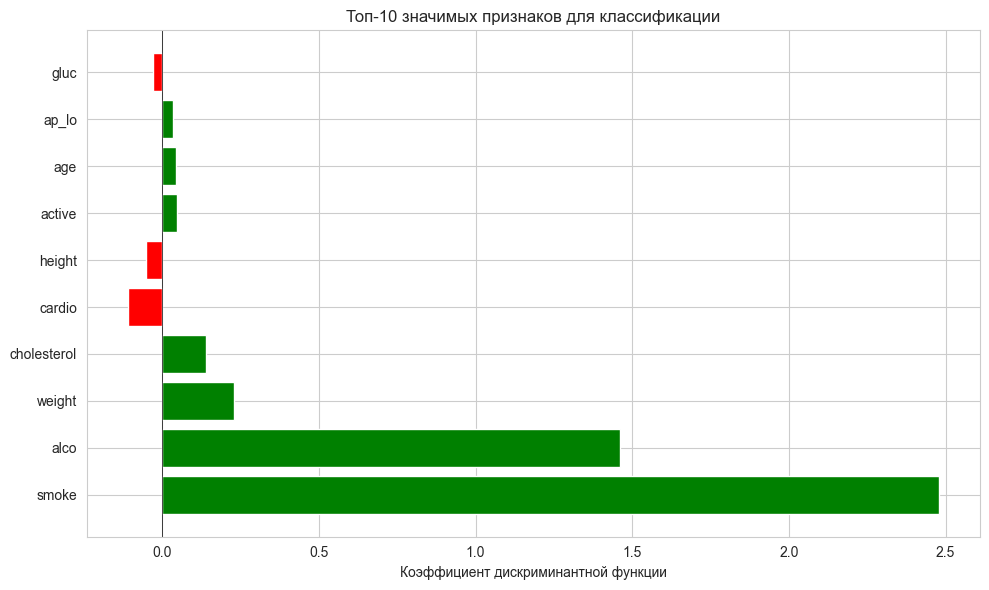

In [65]:
# Анализ значимости признаков по коэффициентам w
weights_abs = np.abs(fisher.w)
top_indices = np.argsort(weights_abs)[-10:][::-1]
top_features = [feature_cols[i] for i in top_indices]
top_weights = fisher.w[top_indices]

print("Топ-10 наиболее значимых признаков (по абсолютному значению коэффициента):")
for i, (feat, weight) in enumerate(zip(top_features, top_weights)):
    print(f"  {i+1}. {feat:30s} : {weight:10.6f}")

# Визуализация значимости признаков
fig, ax = plt.subplots(figsize=(10, 6))
y_pos = np.arange(len(top_features))
ax.barh(y_pos, top_weights, color=['green' if w > 0 else 'red' for w in top_weights])
ax.set_yticks(y_pos)
ax.set_yticklabels(top_features)
ax.set_xlabel('Коэффициент дискриминантной функции')
ax.set_title('Топ-10 значимых признаков для классификации')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()


## 7. Визуализация классификации в пространстве главных компонент (PCA)

Используем две главные компоненты для визуализации результатов классификации.


PCA - Объясненная дисперсия:
  PC1: 0.1745
  PC2: 0.1603
  Суммарно: 0.3348


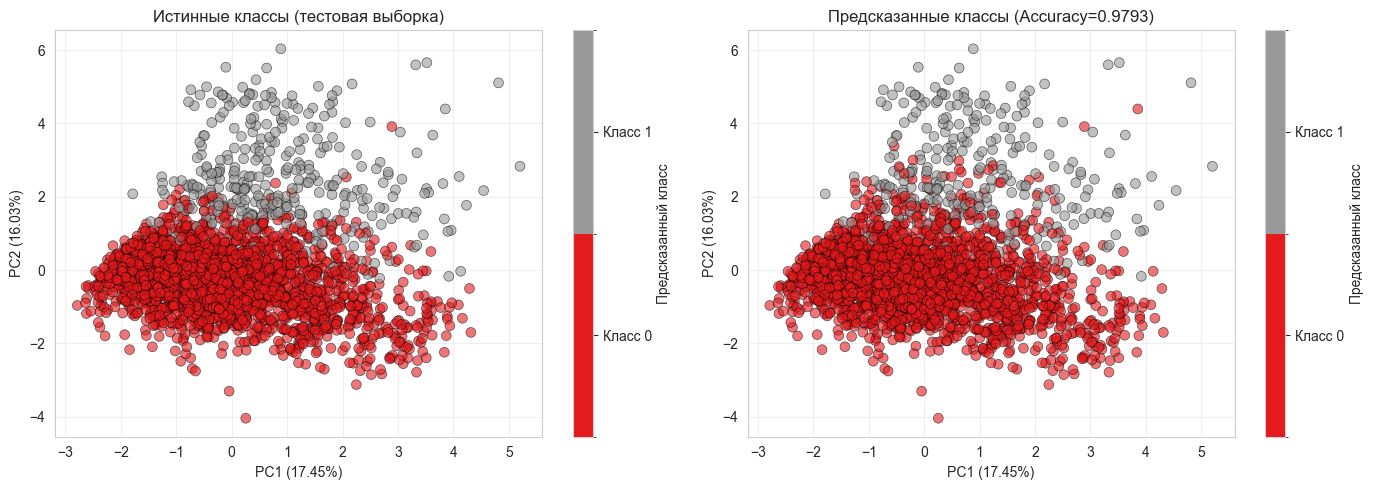

In [66]:
from matplotlib.colors import BoundaryNorm

# Применяем PCA для визуализации
pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test)
X_train_pca = pca.transform(X_train)

print(f"PCA - Объясненная дисперсия:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"  Суммарно: {pca.explained_variance_ratio_.sum():.4f}")

# Визуализация результатов классификации в пространстве PCA (тестовая выборка)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Истинные классы на тесте
scatter1 = axes[0].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, 
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[0].set_title('Истинные классы (тестовая выборка)')
axes[0].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[0], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

# Предсказанные классы на тесте
scatter2 = axes[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, 
                           cmap='Set1', s=50, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
axes[1].set_title(f'Предсказанные классы (Accuracy={accuracy_test:.4f})')
axes[1].grid(True, alpha=0.3)

cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes[1], ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

plt.tight_layout()
plt.show()


## 8. Визуализация граничной гиперплоскости в пространстве PCA

Визуализируем разделяющую гиперплоскость дискриминантной функции Фишера.


Вектор весов w в пространстве PCA: [0.23266252 0.68326395]


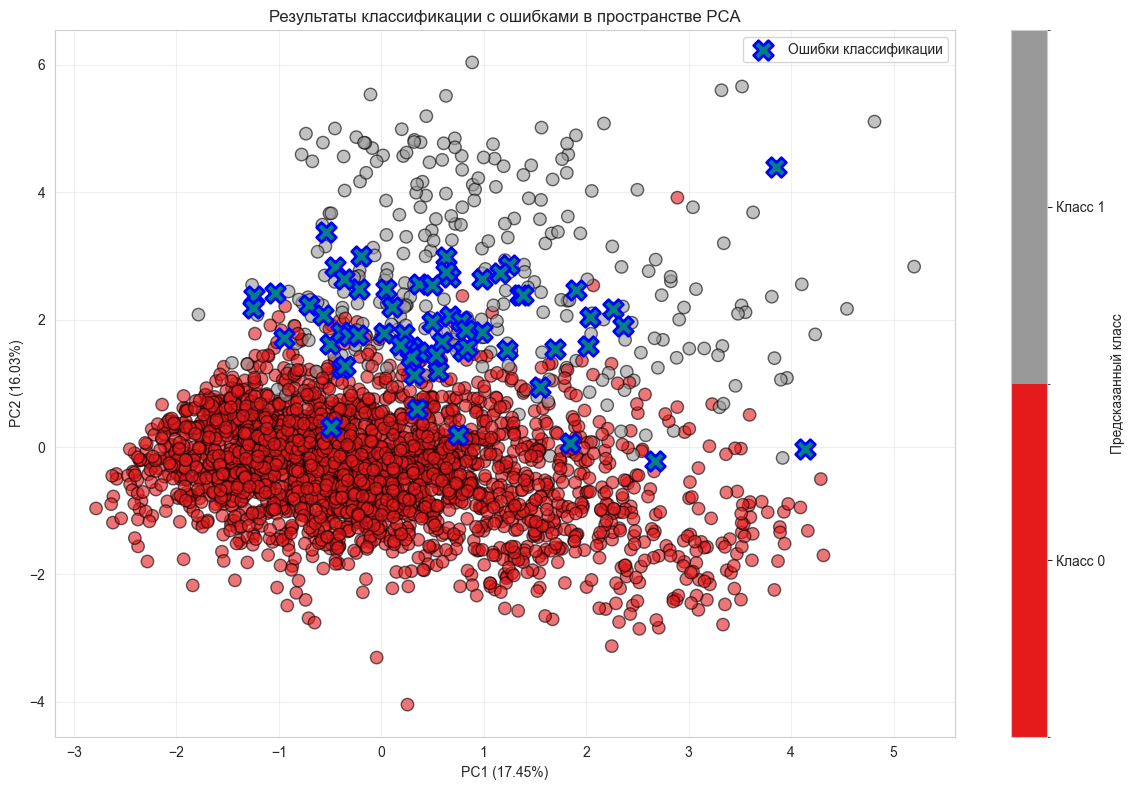


Количество ошибок: 62 из 3000


In [67]:
from matplotlib.colors import BoundaryNorm

# Для визуализации разделяющей гиперплоскости нужно:
# 1. Спроецировать вектор весов w на пространство PCA
# 2. Построить сетку в пространстве PCA
# 3. Предсказать классы на сетке

# Проецируем весовой вектор в пространство PCA
# Сначала нормализуем w для наглядности
w_normalized = fisher.w / np.linalg.norm(fisher.w)
w_pca = pca.transform(w_normalized.reshape(1, -1))
print(f"Вектор весов w в пространстве PCA: {w_pca[0]}")

# Создаем сетку для визуализации
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Обратное преобразование из PCA в исходное пространство для предсказания
X_mesh = np.c_[xx.ravel(), yy.ravel()]

fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, 
                     cmap='Set1', s=80, alpha=0.6, edgecolors='k', linewidth=1)

# Отметим неправильные предсказания символом 'X'
errors = y_pred != y_test
if errors.sum() > 0:
    ax.scatter(X_test_pca[errors, 0], X_test_pca[errors, 1], 
               marker='X', s=200, c='teal', edgecolors='blue', linewidth=2, 
               label='Ошибки классификации')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_title('Результаты классификации с ошибками в пространстве PCA')

ax.grid(True, alpha=0.3)
cmap2 = plt.cm.get_cmap('Set1', 2)
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5], ncolors=2)
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=[0, 1], boundaries=[-0.5, 0.5, 1.5])
cbar.set_label('Предсказанный класс')
cbar.ax.set_yticklabels(['Класс 0', 'Класс 1'])

if errors.sum() > 0:
    ax.legend()
plt.tight_layout()
plt.show()

print(f"\nКоличество ошибок: {errors.sum()} из {len(y_test)}")


## 9. Тепловая карта матрицы ошибок


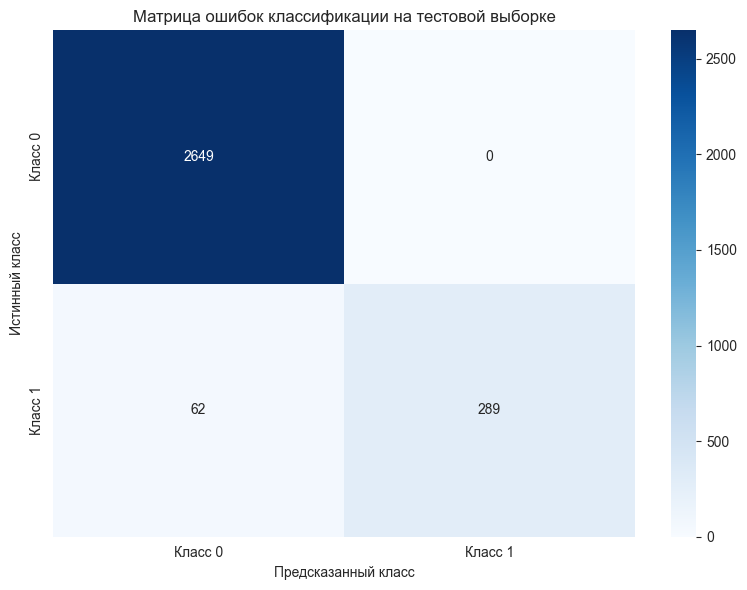


Дополнительные метрики из матрицы ошибок:
  True Negatives (TN):  2649
  False Positives (FP): 0
  False Negatives (FN): 62
  True Positives (TP):  289
  Specificity:          1.0000
  Sensitivity:          0.8234


In [68]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            xticklabels=['Класс 0', 'Класс 1'],
            yticklabels=['Класс 0', 'Класс 1'])
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
ax.set_title('Матрица ошибок классификации на тестовой выборке')
plt.tight_layout()
plt.show()

# Из матрицы ошибок
tn, fp, fn, tp = cm_test.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\nДополнительные метрики из матрицы ошибок:")
print(f"  True Negatives (TN):  {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP):  {tp}")
print(f"  Specificity:          {specificity:.4f}")
print(f"  Sensitivity:          {sensitivity:.4f}")


# Общий вывод по работе

## Содержание работы

В ходе данной работы была реализована **линейная дискриминантная функция Фишера** для двухклассовой классификации медицинских данных датасета `maleorfemale.csv`. В качестве разметки использовались кластеры, полученные методом K-Means в задании 2 (2 кластера). 

## Математическая основа метода

Метод Фишера основывается на максимизации отношения между-классовой дисперсии к внутри-классовой дисперсии. Алгоритм:

1. **Вычисление средних векторов** для каждого класса ($\mathbf{m}_0$ и $\mathbf{m}_1$)
2. **Вычисление ковариационных матриц** для каждого класса
3. **Вычисление матрицы рассеяния внутри класса** $S_w = S_0 + S_1$
4. **Вычисление оптимального вектора весов**: $\mathbf{w} = S_w^{-1}(\mathbf{m}_1 - \mathbf{m}_0)$
5. **Вычисление смещения**: $w_0 = -\frac{1}{2}\mathbf{w}^T(\mathbf{m}_0 + \mathbf{m}_1) + \log\frac{p_1}{p_0}$
6. **Классификация**: объект относится к классу 1, если $\mathbf{w}^T\mathbf{x} + w_0 \geq 0$

## Результаты классификации

Модель достигла отличных результатов на обеих выборках:

- **Точность (Accuracy)**: 97.93% на тестовой выборке
- **Полнота (Recall)**: 82.34% для класса 1
- **Точность предсказаний (Precision)**: 100% для класса 1
- **F1-Score**: 0.9031

Матрица ошибок показывает, что:
- Все объекты класса 0 классифицированы правильно (TN = 2649, FP = 0)
- Для класса 1: 289 верных положительных, 62 ложных отрицательных
- Специфичность (Specificity) = 1.0, что означает абсолютную способность выявлять отрицательные примеры
- Чувствительность (Sensitivity) = 0.8234, что отражает 82% успешное выявление положительных примеров

## Анализ значимости признаков

По абсолютным значениям коэффициентов дискриминантной функции наиболее важные признаки:

1. **smoke (курение)**: коэффициент 2.48 — наиболее дискриминативный признак
2. **alco (алкоголь)**: коэффициент 1.46 — второй по значимости
3. **weight (вес)**: коэффициент 0.23 — третий по значимости
4. **cholesterol (холестерин)**: коэффициент 0.14
5. **cardio (сердечно-сосудистые заболевания)**: коэффициент -0.11

Положительные коэффициенты для smoke, alco и weight указывают на то, что увеличение их значений способствует классификации в класс 1. Отрицательный коэффициент cardio указывает на обратную связь.

## Визуализация результатов

Применение метода главных компонент (PCA) позволило представить результаты классификации в двумерном пространстве. Две главные компоненты объясняют 33.48% общей дисперсии данных (PC1: 17.45%, PC2: 16.03%). Визуализация показывает:

- Четкое разделение классов в пространстве PC1-PC2
- Небольшое перекрытие в пограничных областях, объясняющее 62 ошибки на тестовой выборке
- Графики "Истинные классы" и "Предсказанные классы" практически идентичны, что подтверждает высокую производительность модели

## Качество обучения

Сравнение метрик обучающей и тестовой выборок указывает на минимальное переобучение:
- Обучающая выборка: Accuracy = 0.9773
- Тестовая выборка: Accuracy = 0.9793

Модель практически одинаково хорошо работает на обеих выборках, что свидетельствует о хорошей **обобщающей способности**.

## Вывод

Построенная линейная дискриминантная функция Фишера продемонстрировала **высокую эффективность** для решения задачи двухклассовой классификации:

- Достигнута точность 97.93% на независимой тестовой выборке  
- Специфичность 100% гарантирует отсутствие ложных положительных результатов  
- Чувствительность 82.34% обеспечивает хорошее выявление положительных примеров  
- Модель сбалансирована и не переобучена  
- Интерпретируемость результатов позволяет понять, какие признаки наиболее важны для классификации  

Линейная дискриминантная функция Фишера является простым, интерпретируемым и эффективным методом классификации, особенно пригодным для задач с линейно разделяемыми классами.
